In [1]:
import svetlanna as sv
from svetlanna.units import ureg
import matplotlib.pyplot as plt

from svetlanna import Wavefront
from svetlanna import SimulationParameters
from svetlanna.elements import FreeSpace

from svetlanna.elements import Aperture, RectangularAperture, RoundAperture, DiffractiveLayer

from svetlanna.visualization import show_stepwise_forward

import torch

# Апертуры

Одно из самых интересных явлений в оптике - дифракция света. Дифракция — это явление огибания волнами препятствий или отклонения волн от прямолинейного распространения, что приводит к появлению характерных интерференционных картин света или других волн. Проще говоря, когда волна встречает на своем пути препятствие или проходит через узкое отверстие, она не просто продолжается по прямой, а «огибает» края этого препятствия, распространяясь в область геометрической тени и создавая сложные узоры из максимумов и минимумов интенсивности.

На практике для управляемого изменения волнового фронта используют различные дифракционные элементы. В частности, используются апертуры различной формы для фокусировки пучка.

В нашей библиотеке апертуры произвольной, круглой и прямоугольной форм представлены в модуле ```elements``` классами ```Aperture```, ```RoundAperture``` и ```RectangularAperture``` соответственно. 

## Задание 1

Рассмотрите плоскую волну(пучок Гаусса), которая падает на апертуру. С помощью средств библиотеки рассчитайте дифракционную картину, которая получится после распространения света от апертуры до экрана на некоторое расстояние $z>0$. Необходимо использовать как класс ```Aperture```, так и класс ```FreeSpace```

In [10]:
sim_params = SimulationParameters(
    {
        "W": torch.linspace(-5, 5, 400) * ureg.cm,
        "H": torch.linspace(-5, 5, 400) * ureg.cm,
        "wavelength": 0.25 * ureg.mm,
    }
)

In [16]:
round_aperture = lambda: RoundAperture(
    sim_params,
    radius=1 * ureg.cm
)
rect_aperture = lambda: RectangularAperture(
    sim_params,
    width=1 * ureg.cm,
    height=1 * ureg.cm
)

In [25]:
beam = Wavefront.gaussian_beam(
    sim_params,
    waist_radius=1 * ureg.cm
)
free_space = FreeSpace(
    sim_params,
    30 * ureg.mm,
    method='AS'
)

beam_after_rect = free_space(rect_aperture()(free_space(beam)))
beam_after_round = free_space(round_aperture()(free_space(beam)))

c:\Users\soflu\OneDrive\Документы\DNN\.venv\Lib\site-packages\svetlanna\elements\free_space.py:153: UserWarning: Aliasing problems may occur in the AS method. Consider reducing the distance or increasing the Nx*dx product.
  warn(
c:\Users\soflu\OneDrive\Документы\DNN\.venv\Lib\site-packages\svetlanna\elements\free_space.py:159: UserWarning: Aliasing problems may occur in the AS method. Consider reducing the distance or increasing the Ny*dy product.
  warn(


In [26]:
def plot_beam(beam, title):
    plt.pcolormesh(sim_params.axes.W, sim_params.axes.H,
                   beam.intensity)
    plt.gca().set_aspect('equal')
    plt.xlim(-1 * ureg.cm, 1 * ureg.cm)
    plt.ylim(-1 * ureg.cm, 1 * ureg.cm)
    plt.colorbar(label='Intensity')
    plt.title(title)
    plt.show()

In [27]:
#Aperture(mask=as)

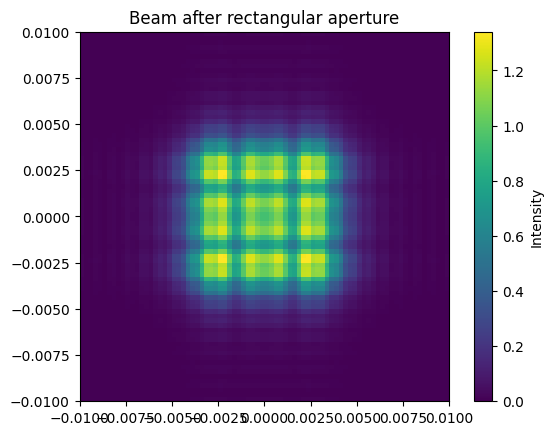

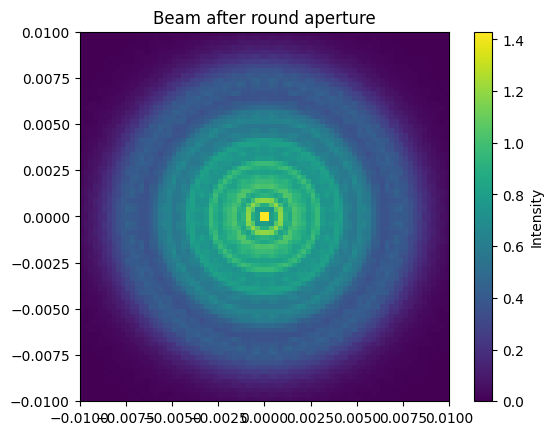

In [28]:
plot_beam(beam_after_rect, "Beam after rectangular aperture")
plot_beam(beam_after_round, "Beam after round aperture")

# Визуализация

In [29]:
show_stepwise_forward(
    free_space,
    input=beam_after_rect,
    simulation_parameters=sim_params,
    types_to_plot=("I",),
)

StepwiseForwardWidget(elements=[{'index': 0, 'name': 'FreeSpace', 'output_image': 'iVBORw0KGgoAAAANSUhEUgAAAlg…

In [32]:
elements_list = [
    round_aperture(),
    free_space,
    rect_aperture(),
    free_space,
    round_aperture(),
    free_space
] 

setup = sv.LinearOpticalSetup(
    elements_list
)

show_stepwise_forward(
    setup,
    input=beam,
    simulation_parameters=sim_params,
    types_to_plot=("I", "Re", "Im", "phase", "A"),
)

StepwiseForwardWidget(elements=[{'index': 0, 'name': 'LinearOpticalSetup', 'output_image': 'iVBORw0KGgoAAAANSU…

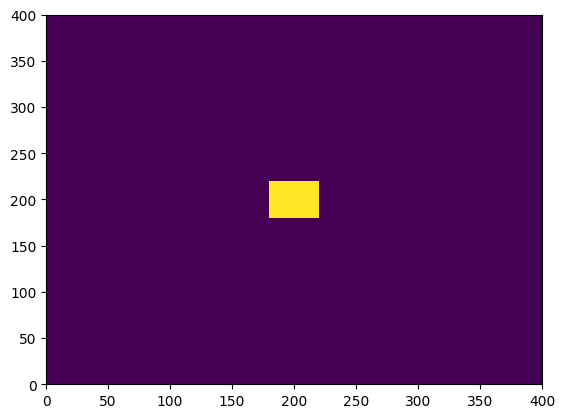

In [38]:
ap = rect_aperture()
for i in range(400):
    ap._mask[0][i] = ap._mask[i][0] = 0.5
plt.pcolormesh(rect_aperture().get_transmission_function())

# Опыт Юнга

Интерференция — это физическое явление, при котором происходит взаимное увеличение или уменьшение результирующей амплитуды двух или нескольких когерентных волн при их наложении друг на друга.

Когда волны накладываются, их колебания складываются по принципу суперпозиции: в тех точках, где волны совпадают по фазе, амплитуды усиливаются, образуя интерференционные максимумы (яркие полосы или участки), а в тех местах, где волны находятся в противофазе, амплитуды уменьшаются или взаимно гасятся, образуя интерференционные минимумы (тёмные полосы или участки).

Для наблюдения устойчивой интерференционной картины необходимо, чтобы волны были когерентными — то есть имели постоянную разность фаз во времени и одинаковую частоту. Если волны некогерентны, интерференционные эффекты усредняются и не дают ярко выраженной картины

Опыт Юнга (двухщелевой эксперимент) — это классический физический опыт, который Томас Юнг провёл в 1801 году для изучения природы света. Суть эксперимента такова: на непрозрачном экране делают две узкие, близко расположенные щели, через которые пропускают свет от одного источника. За щелями располагают экран для наблюдения картины, возникающей после прохождения света через щели

В результате на экране появляется не две светлых полосы (как ожидалось бы для частиц), а сложная чередующаяся система светлых и тёмных полос — интерференционная картина. Это объясняется тем, что свет, проходя через обе щели, ведёт себя как волна: волны от каждой щели накладываются друг на друга, усиливаясь в одних местах (светлые полосы) и ослабляясь в других (тёмные полосы)

Что доказал опыт Юнга:

1. Доказательство волновой природы света. Появление интерференционной картины возможно только при наложении волн, а не частиц. Это стало решающим аргументом в пользу волновой теории света, опровергнув исключительно корпускулярную (частичную) теорию Ньютона, господствовавшую до этого опыта.

2. Введение понятия интерференции. Юнг впервые ввёл термин и объяснил явление интерференции — наложения волн с одинаковой частотой, приводящего к усилению или ослаблению результирующей волны.

3. Демонстрация когерентности. Эксперимент показал важность когерентности (согласованности фаз) для возникновения устойчивой интерференционной картины

## Задание 2

1. С помощью класса ```Aperture``` из модуля ```elements``` создайте апертуру, состоящую из двух тонких щелей

2. Посчитайте дифракционную картину, которая получается после прохождения светового пучка через апертуру на расстоянии $z>0$

3. Поменяйте апертуру, сделав из нее непрозрачную полосу

In [11]:
sim_params = SimulationParameters(
    {
        "W": torch.linspace(-5, 5, 400) * ureg.cm,
        "H": torch.linspace(-5, 5, 400) * ureg.cm,
        "wavelength": 0.25 * ureg.mm,
    }
)


a = 0.2 * ureg.cm  # расстояние между щелями
d = 0.3 * ureg.cm  # ширина щели

In [96]:
x_grid, y_grid = sim_params.meshgrid('W', 'H')

# создать маску
mask = torch.full_like(x_grid, 0)
for x, i in enumerate(x_grid[0]):
    if (abs(len(x_grid[0]) / 3 - x) < 10) or (abs(len(x_grid[0]) * 2 / 3 - x) < 10):
       mask[:, x] = torch.tensor([1] * len(x_grid[:, 0]))

d1 = max(sim_params.axes.W) * 3 / 7
d2 = max(sim_params.axes.W) * 1 / 7
w = max(sim_params.axes.W) / 20
print(f"{d1=}")
print(f"{d2=}")
print(f"{w=}")
#  |----d1----|----d2----|---rest---|

mask = (abs(x_grid - d1) < w) | (abs(x_grid - d1 - d2) < w)


d1=tensor(0.0214)
d2=tensor(0.0071)
w=tensor(0.0025)


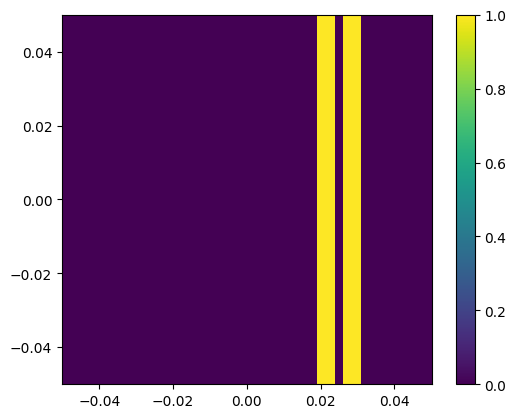

In [94]:
plt.pcolormesh(
    x_grid,
    y_grid,
    mask
)
plt.gca().set_aspect('equal')
plt.colorbar()

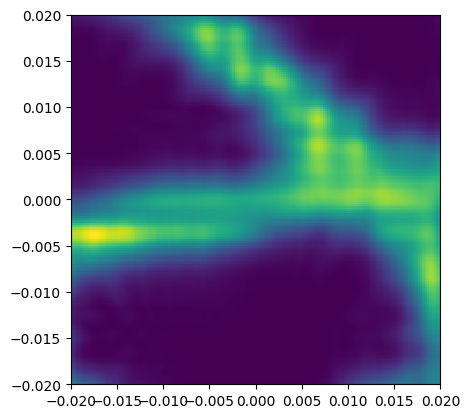

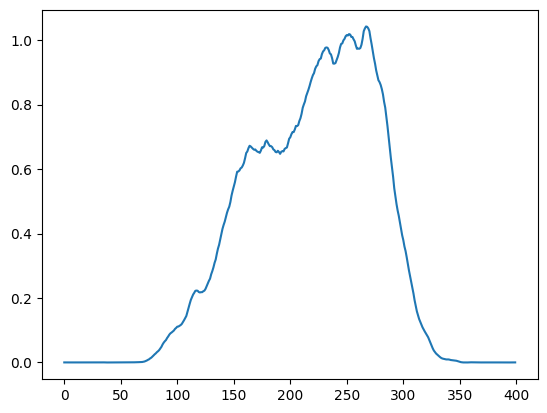

In [110]:
aperture = Aperture(
    sim_params, mask=mask
)

free_space = FreeSpace(
    sim_params,
    10 * ureg.cm,
    method='AS'
)

plt.pcolormesh(
    sim_params.axes.W,
    sim_params.axes.H,
    free_space(aperture(Wavefront.gaussian_beam(
    sim_params,
    waist_radius=10 * ureg.cm
))).intensity
)
plt.xlim(-20 * ureg.mm, 20 * ureg.mm)
plt.ylim(-20 * ureg.mm, 20 * ureg.mm)
plt.gca().set_aspect('equal')
plt.show()

plt.plot(FreeSpace(sim_params, 15 * ureg.cm, method="AS")(
    aperture(
        Wavefront.plane_wave(sim_params)
    )
).intensity[400//2])
plt.show()

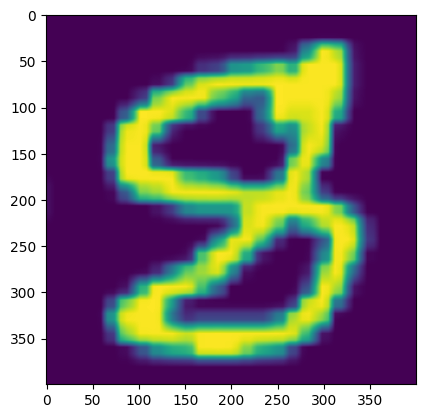

In [100]:
import torchvision.io as io
import torchvision.transforms as transforms
import torch

mask = io.read_image("8.png", mode=io.ImageReadMode.GRAY).squeeze(0).float() / 255.0

import torch.nn.functional as F

mask = F.interpolate(
        mask.unsqueeze(0).unsqueeze(0),
        size=(400, 400),
        mode='bilinear',
        align_corners=False
    ).squeeze(0).squeeze(0)
plt.imshow(mask)

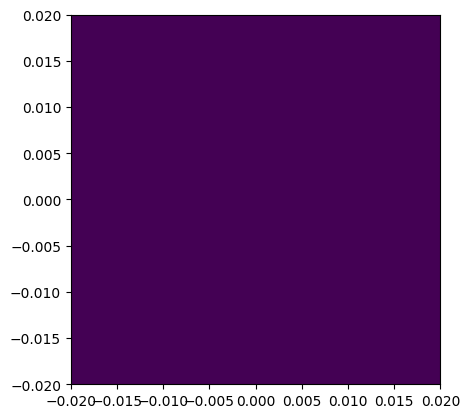

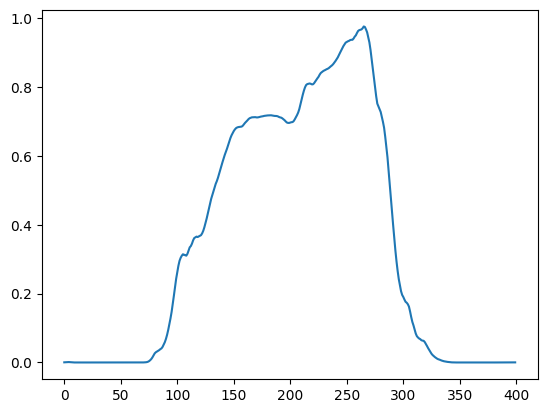

In [112]:
aperture = Aperture(
    sim_params, mask=mask
)

free_space = FreeSpace(
    sim_params,
    1 * ureg.cm,
    method='AS'
)
beam = Wavefront.plane_wave(sim_params)
plt.pcolormesh(
    sim_params.axes.W,
    sim_params.axes.H,
    free_space(beam).intensity
)
plt.xlim(-20 * ureg.mm, 20 * ureg.mm)
plt.ylim(-20 * ureg.mm, 20 * ureg.mm)
plt.gca().set_aspect('equal')
plt.show()

plt.plot(free_space(
    aperture(beam)
).intensity[400//2])
plt.show()

# Дифракционный слой

![alt text](image.png)

$$\vec{E}(x,y,z+\Delta z)=\vec{E}(x,y,z) e^{ikn\Delta z}$$

## Задание 3
1. Сделать рандомный дифракционный слой, с набегом фазы от 0 до $a\cdot2\pi$.
    - Рассчитать интенсивность пучка Гаусса после прохождения через дифракционный слой и свободное пространство
    - Рассчитать интенсивность пучка Гаусса после прохождения через дифракционный слой, апертуру из предыдущего задания и свободное пространство

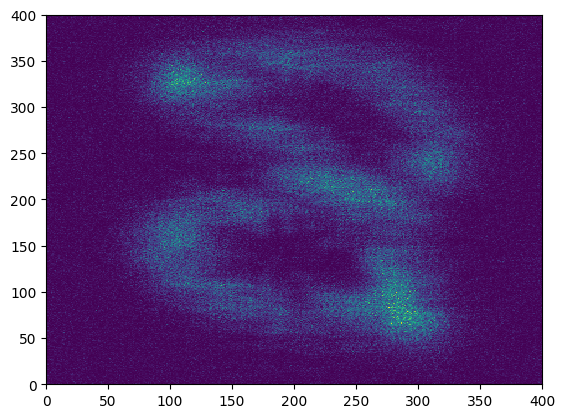

In [ ]:
free_space = FreeSpace(
    sim_params,
    50 * ureg.cm,
    method='AS'
)
diff = DiffractiveLayer(sim_params, mask = 0.6 * torch.pi * torch.rand(beam.shape))
masked = Aperture(sim_params, mask=mask)
los = sv.LinearOpticalSetup([diff, free_space, masked, free_space])
plt.pcolormesh(los(beam).intensity)

# Линза

$$
e^{-ik(x^2+y^2)/(2f)}
$$
где $k$ - волновой вектор, $f$ - фокусное расстояние
$$
k = 2\pi / \lambda
$$

## Задание 4
1. Создать дифракционный слой, который работает как линза.
Рассчитать световое поле после прохождения через него и свободное пространство плоской волны; проверить, что слой работает как линза
2. Поменять направление плоской волны, проследить за поведением интенсивности в фокальной плоскости
3. Расчитать поле после прохождения дифракционного двух волн одновременно с разной интенсивностью
4. Построить 4f систему
    - Создать волновой фронт с каким-нибудь распределением амплитуды
    - Создать `LinearOpticalSetup`, соответвующий 4f системме
    - Расчитать световое поле после прохождения волнового фронта через эту систему

In [139]:
k = 2 * torch.pi / sim_params.axes.wavelength
f = 10 * ureg.cm

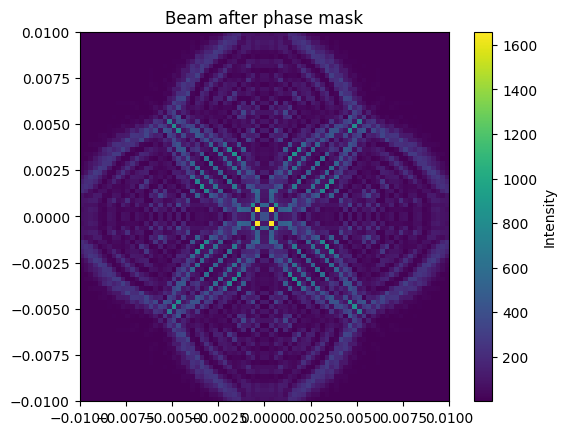

In [173]:
def phase_shift(x, y):
    return -k * (x**2 + y**2) / (2 * f)

x_grid, y_grid = sim_params.meshgrid('W', 'H')
phase_mask = DiffractiveLayer(sim_params, phase_shift(x_grid, y_grid))
waves = [Wavefront.plane_wave(sim_params, wave_direction=dir) for dir in [[0, 0.05, 1], [0.05, 0, 1], [0, -0.05, 1], [-0.05, 0, 1]]]
plot_beam(FreeSpace(
    sim_params,
    8 * ureg.cm,
    method='AS'
)(phase_mask(sum(waves))), "Beam after phase mask")